# Lecture 7: Variance Reduction

Topics:

* Overview
* Control variate
* Importance sampling
* Low discrepency sequence
* Other techniques

In [1]:
%pylab inline
import pandas as pd
import fmt

lecture = 7

Populating the interactive namespace from numpy and matplotlib


# Overview

## Estimator variance 

Let's consider the simple average estimator for $\mathbb{E}[\tilde x]$:

$$\renewcommand{var}{\text{var}}\renewcommand{std}{\text{std}}\renewcommand{cov}{\text{cov}}\renewcommand{bs}{\boldsymbol} \hat{u} = \frac{1}{n}\sum_i x_i$$

* $x_i$ are samples of the random variable $\tilde x$. 
* $\hat{u}$ is an unbiased estimator: $\mathbb{E}[\hat{u}] = \mathbb{E}[\tilde x]$
* the error of the estimator is: $\std[\hat{u}] = \frac{\sigma}{\sqrt{n}}$, $\sigma^2$ is the population variance of $\tilde x$.

## Total MC cost

The minimum number of samples erquired for a given accuracy $\epsilon$ is:

$$\frac{\sigma}{\sqrt{n}} = \epsilon \iff n = \frac{\sigma^2}{\epsilon^2}$$ 

The total computation cost is therefore roughly $c(x_i)\frac{\sigma^2}{\epsilon^2}$:

* $c(x_i)$ is the cost to generate one random sample of $x_i$
* out of the three factors, variance has the greatest potential for reduction

Variance reduction is extremely important in practice
* MC is often applied to exotic, complex and large scale problems, speed is the critical bottleneck
* advanced variance reduction could lead to many times of speedups

## Variance reduction strategies

Sample an alternative random variable $\tilde y$ that has identical mean but smaller variance than $\tilde x$:

* Antithetic variate
* Control variate

Use more efficient estimator than the mean of independent random samples:

* Importance sampling
* Low-discrepency sequence (aka Quasi-random sequence)
* Moment matching
* Stratified sampling

## Antithetic variates

Suppose $\tilde x(\bs w(t))$ is driven by an multi-d Brownian motion $\bs w(t)$, 

$$\tilde y = \frac{1}{2} \left(\tilde x\left(\bs w\left(t\right)\right) + \tilde x\left(-\bs w\left(t\right)\right)\right) $$

* $\tilde y$ is the average of two $\tilde x$ from mirroring Brownian paths
* $\mathbb{E}[\tilde y] = \mathbb{E}[\tilde x]$, the mirror of a Brownian path is also a Brownian
* $\var[\tilde y] = \frac{\sigma^2}{2}\left(1 + \rho\left(\tilde x\left(\bs w\right),\tilde x\left(-\bs w\right)\right)\right)$

Effectiveness depends on the payoff:
* the cost of every sample doubled, i.e., $c(\tilde y) = 2c(\tilde x)$
* to ensure an overall saving in computational cost:
$$ \var[\tilde y] < \frac{\sigma^2}{2}  \iff \rho\left(\tilde x\left(\bs w\right),\tilde x\left(-\bs w\right)\right)< 0 $$

## Effectiveness of antithetic variates

works the best when the $\tilde x$ is a linearish function of the underlying $\bs w(t)$

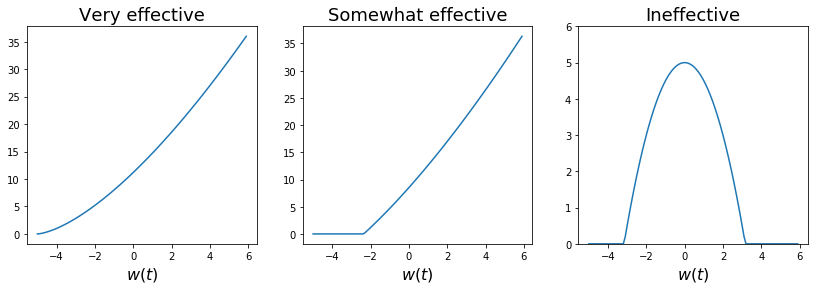

In [2]:
x = np.arange(0, 11, .1) -5

figure(figsize=[14, 4])
subplot(1, 3, 1)
plot(x, (x+5)**1.5);
title('Very effective', fontsize=18)
xlabel('$w(t)$', fontsize=16)

subplot(1, 3, 2)
plot(x, np.maximum((x+7)**1.5 - 10, 0))
title('Somewhat effective', fontsize=18)
xlabel('$w(t)$', fontsize=16)

subplot(1, 3, 3)
plot(x, np.maximum(5-.5*x**2, 0))
ylim(0, 6.)
title('Ineffective', fontsize=18);
xlabel('$w(t)$', fontsize=16);

Antithetic variate is often abused in practice
* very easy to implement, often turned on without cost/benefits analysis
* it conflicts with other advanced variance reduction technique

# Control Variate

it is better to be precisely wrong than roughly right

<img src=http://www.uh.edu/engines/accurate-precise.jpg width=400>

## Motivation

Exotic trades are often 90% vanilla, but with a small exotic feature
* the vanila trade is often a good proxy to the exotic trade
* e.g. Asian option vs. vanilla European option
  * Asian payoff is computed from average prices

We therefore price the (exotic - vanilla) instead of the full exotic instrument:
* the difference has much smaller variance
  * e.g., for two paths: Asian option [10, 0], European option [9, 0], the diff is [1, 0]
* we can recover the exotic trade's price by adding back the price of vanilla trade 

## Control Variate

Express the idea of diffs formally:

$$ \tilde y = \tilde x + \beta (v - \tilde v) $$

* $\tilde v$ is the control variate, which represents the similar vanilla instrument
* $v = \mathbb{E}[\tilde v]$ is the true value of the vanilla instrument, which is known to very high precision (e.g. analytical or PDE)
* $\beta$ is a scalar constant, a free parameter
* $\mathbb{E}[\tilde y] = \mathbb{E}[\tilde x]$ by construction

## Optimal $\beta$
$\beta$ is determined by minimizing $\tilde y$'s variance: 

$$\begin{array}{l} \var[\tilde y] &= \cov(\tilde y, \tilde y) = \cov(\tilde x -\beta \tilde v, \tilde x -\beta \tilde v) \\
&= \sigma_x^2 - 2 \beta \cov(\tilde x, \tilde v) + \beta^2 \sigma_v^2  \\
\frac{\partial \var[\tilde y]}{\partial \beta} &= -2 \cov(\tilde x, \tilde v) + 2\beta \sigma_v^2 = 0 \\
\beta^* &= \frac{\cov(\tilde x, \tilde v)}{\sigma_v^2} = \frac{\rho(\tilde x, \tilde v)\sigma_x}{\sigma_v}
\end{array}$$

The minimum variance is therefore: $\var[\tilde y] = \sigma_x^2\left(1-\rho^2(\tilde x, \tilde v)\right)$
* the higher the correlation between $\tilde x, \tilde v$, the more variance reduction
* significant performance gain with the right control variate
* $\tilde x, \tilde v$ must be driven by the same Brownian paths to ensure high correlation

## Asian option

Consider the following Asian call option:
* $s(0) = 100, k=100, \sigma = .25$, maturity $t_m = 1$Y
* constant countinuous risk free rate of $r=0.02$
* payoff at maturity is based on monthly average of stock prices: 
$$\left(\frac{1}{n}\sum_{i=1}^{n} s(i\delta) - k\right)^+$$
with $\delta = \frac{1}{12}, n=\frac{t_m}{\delta} = 12$

A straight Monte Carlo simulation of 100,000 paths yields:

In [3]:
import proc, time

s0, k, vol, tm, dt, r = 100., 100., .25, 1., 1./12, 0.02
n = int(tm/dt + 1e-6) # why 1e-6?
gbm = proc.GBM(r, vol)
disc = np.exp(-r*tm)

def mc0(p, es) :
    ss = gbm.draw(es, s0, dt)
    x = np.maximum(np.mean(ss, 1) - k, 0)*disc
    return np.mean(x), np.sqrt(np.var(x)/p)

p0 = 100000
tic = time.clock()
es = np.random.normal(size=[p0, n])
u0, e0 = mc0(p0, es)
t0 = time.clock() - tic

df = pd.DataFrame([p0, u0, e0], index=['Paths', 'Value', 'MC error'], columns=['Asian Call'])
fmt.displayDF(df.T, "3g", 4)

,Paths,Value,MC error
Asian Call,1e+05,6.63,0.0324


## European option as control

We use the European option with the same strike and maturity as control
* the European options value (Black Scholes): $v = \mathbb{E}[\tilde v] = 10.871$
* this simple control reduces the computational cost by about four times

In [4]:
import inst

euro_call_v = inst.BlackScholes.callPrice(r, s0, k, tm, vol)
euro_call_f = lambda ss : np.maximum(ss[:,-1]-k, 0.)*disc
asian_call_f =  lambda ss: np.maximum(np.mean(ss, 1) - k, 0)*disc

def mc_cv(p, xf, vf, ve) :
    es = np.random.normal(size=[p, n])
    ss = gbm.draw(es, s0, dt)
    x = xf(ss)
    v = vf(ss)
    
    rho = np.corrcoef(x, v)[0, 1]
    beta = rho*np.std(x)/np.std(v)
    
    y = x + beta*(ve - v)
    return np.mean(y), np.sqrt(np.var(y)/p), x, v, rho, beta

tic = time.clock()
cv1 = mc_cv(p0, asian_call_f, euro_call_f, euro_call_v)
t1 = time.clock() - tic

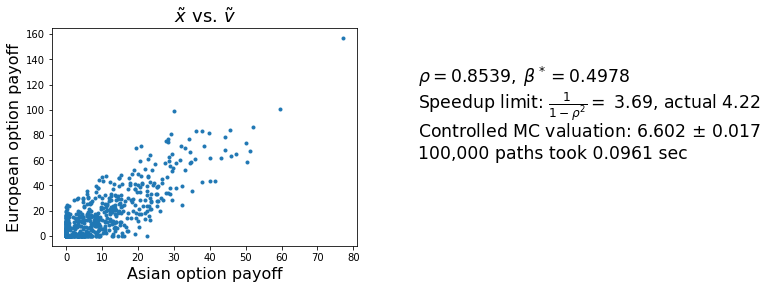

In [5]:
def chart_cv(cv, actual, t, p, control) :
    u, e, x, v, rho, beta = cv
    fig = figure(figsize=[12, 4])
    subplot(1, 2, 1)
    plot(x[:1000], v[:1000], '.')

    xlabel('Asian option payoff', fontsize=16)
    ylabel(control, fontsize=16)
    title('$\\tilde x$ vs. $\\tilde v$', fontsize=18);

    subplot(1, 2, 2)
    ax = fig.add_subplot(122)
    ax.text(0, .75, "$\\rho=%.4f, \; \\beta^*=%.4f$" % (rho, beta), size="xx-large")
    ax.text(0, .63, "Speedup limit: $\\frac{1}{1-\\rho^2} =$ %.2f, actual %.2f" % \
            (1./(1.-rho*rho), actual), size="xx-large")
    ax.text(0, .50, "Controlled MC valuation: %.3f $\\pm$ %.3f" % (u, e), size="xx-large")
    ax.text(0, .40, "%s paths took %.3g sec" % ("{:,}".format(p), t), size="xx-large")

    ax.set_axis_off()
    
e1 = cv1[1]
chart_cv(cv1, t0/t1*e0*e0/e1/e1, t1, p0, "European option payoff")

Can we do better than a 4x speed up? You bet!

## Geometric Asian option

Consider the geomeric mean of the stock prices: 

$$ g = \exp\left(\sum_{i=1}^{n} \log\left(s\left(i\delta\right)\right)\right) $$

* $g$ follows a lognormal distribution with known mean and variance
* $g$ is a close approximation to the arithmetic mean

Consider a call option with the following payoff:

$$\left(g - k\right)^+$$

* can be priced exactly by Black-Scholes, (or another MC simulation)
* not a real tradable instrument, but it does not matter

## A stellar control

The results using the geometric Asian option control:

In [6]:
g_call_v = 0
g_call_f = lambda ss : np.maximum(np.exp(np.mean(np.log(ss), 1)) - k, 0)*disc

pc = 1200000
cvc = mc_cv(pc, g_call_f, euro_call_f, euro_call_v)

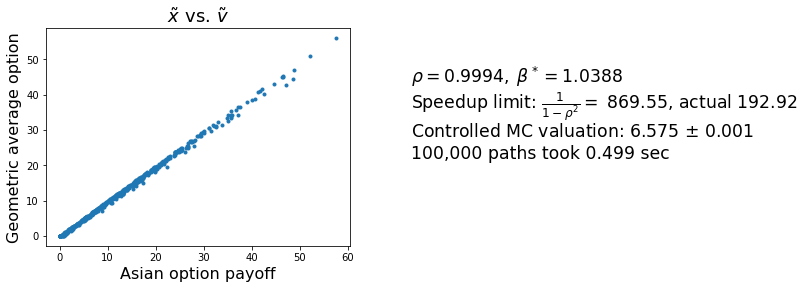

In [7]:
tic = time.clock()
cv2 = mc_cv(p0, asian_call_f, g_call_f, cvc[0])
t2 = time.clock() - tic

chart_cv(cv2, t0/t2*(e0/cv2[1])**2, t2, p0, "Geometric average option")

Disclaimer: such dramatic reduction in variance is not typical:
* 10x - 20x reduction is an exellent result in practice

## Control for LSMC

When pricing early exercise options using LSMC, the European version could be used as a control.

In [8]:
import mc
from inst import BlackScholes

t, m, r, s0, k, vol = 1., 52, .1, 100., 100., .25
bs_v = BlackScholes.putPrice(r, s0, k, t, vol)

dt = t/m 
n = 40000

ts = np.arange(1, m+1)*dt

gbm = proc.GBM(r, vol)

bvs = []

for b in range(30) :
    spath = gbm.draw(np.random.normal(size=[n, m]), s0, dt)

    eput = np.maximum(k-spath[:,-1], 0)*np.exp(-r*t)
    u = np.mean(eput)
    e = np.std(eput)/sqrt(n)

    #print "European call price is %.2f, MC err %.2g" % (u, e) 
    put_ev = lambda x : np.maximum(k - x, 0)
    v_b, e_b, b_b, cvs = mc.amer_opt(spath, exp(-r*dt), put_ev, mc.fit_ex)

    au = cvs[:, 0]
    c = np.corrcoef(eput, au)[0, 1]*np.std(au)/np.std(eput)
    #print "American put value from LSMC is %.3f" % v_b
    d = au + c*(bs_v - eput)
    bvs.append((np.mean(d), v_b))

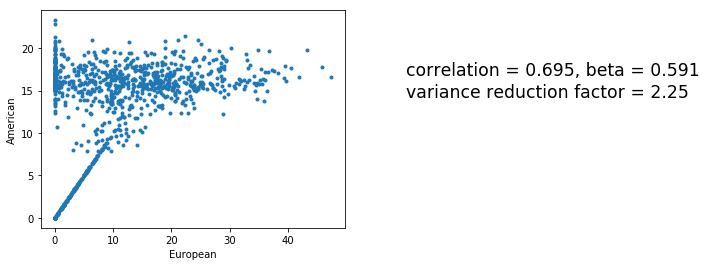

In [9]:
fig = figure(figsize=[12, 4])

subplot(1, 2, 1)
plot(eput[:2000], au[:2000], '.')
xlabel('European')
ylabel('American');

ax = fig.add_subplot(122)
ax.set_axis_off()
c = np.corrcoef(eput, au)[0, 1]
b = c*np.std(au)/np.std(eput)
bm = np.mean(bvs, 0)
bs = np.var(bvs, 0)
ax.text(0, .7, "correlation = %.3f, beta = %.3f" % (c, b), size="xx-large")
ax.text(0, .6, "variance reduction factor = %.2f" % (bs[1]/bs[0]), size="xx-large");

* though the American option's valuations per path are not strictly independent, their couplings are weak
* using European option payoff as a control gives a nice variance reduction for very little effort

## Antithetic variable revisited

AV is a poor man's control variate:

$$\begin{array}{l}
\tilde y &= \frac{1}{2} \left(\tilde x\left(\bs w\left(t\right)\right) + \tilde x\left(-\bs w\left(t\right)\right)\right) \\
&= \tilde x\left(\bs w\left(t\right)\right) + \frac{1}{2} \left(\tilde x\left(-\bs w\left(t\right)\right) - \tilde x\left(\bs w\left(t\right)\right) \right) \\
\end{array}$$

The control variate is $\tilde v = \frac{1}{2} \left(\tilde x\left(\bs w\left(t\right)\right) - \tilde x\left(-\bs w\left(t\right)\right) \right)$, and $v = \mathbb E[\tilde v] = 0 $

* control variate is much more flexible than AV

## Control variate summary

Control variate is the most potent variance reduction technique, 
* could lead to orders of magnitude of speed up
* the choice of control variate is critical, it is problem specific 
* its implementation requires creativity and highly specialized skills

It can also be used to compute deltas with Monte Carlo simulation

# Importance Sampling

You have a 99% chance of winning the lottery!

## Extreme events

We often need to simulate rare or extreme events:

* CDS pricing: default event of high grade issuers
* CDO tranches: multiple defaults in a portfolio
* Extreme quantile measures: 
  * VaR: 99% 10 day
  * IRC/CRM: 99.9% 1Y
  * PFE: 98%

Simulating rare events is very inefficient, 
* most simulated paths do not hit the area of interests. 

## Bernoulli trial

Consider buying a lottery ticket that pays $g = $\$1 billion, with the chance of winning being $p$:

The variance of the payoff is: 

$$\var[\tilde x] = \mathbb{E}[\tilde x^2] - \mathbb{E}[\tilde x]^2 = g^2(p - p^2)$$

Suppose we want to price the payoff to a relative accuracy of 1% using Monte Carlo, then the minimum number of sample path $n$ is:

$$ g \sqrt{\frac{p-p^2}{n}} < .01 g\cdot p \iff n > 10^4\frac{1-p}{p}$$

The relationship between $p$ and the computational costs:

In [10]:
import fmt

p = np.array([1e-8, 1e-4, .01, .1, .5, .9, .99, 1-1e-4])
n = 1e4*(1-p)/p
df = pd.DataFrame(np.array([p, n]), index=["$p$", "Min Paths"])
df = df.T.set_index("$p$")
fmt.displayDF(df.T, "4g", 4)

$p$,1e-08,0.0001,0.01,0.1,0.5,0.9,0.99,0.9999
Min Paths,1e+12,9.999e+07,9.9e+05,9e+04,1e+04,"1,111",101,1


# Pitfalls with sampling extrememe events

Consider the following scenario of winning odds $p=10^{-8}$:

- We draw 10,000 MC sample path and none of them hit the positive payoff
- The average of the 10,000 paths gives incorrect value of 0. 
- but MC error  estimated from the samples is $\frac{\hat s}{\sqrt{n}} = 0$.

Why and how the MC error estimation failed us?

Because of the large error of MC error $\sqrt{\frac{\beta-1}{4n}}\frac{\sigma}{\sqrt{n}}$, in this case the kurtosis $\beta$ is very large, $\beta >> n = 10,000$.

## Intuitions of importance sampling

The expected payoff is the same between the two lotteries:

1. $p=10^{-8}$ chance of winning \$1 billion 
2. $p=.99$ chance of winning $10.10

Let's pretend that we are playing lottery #2 in the MC.

Everybody wins!

* sample mean is unchanged
* lottery #2 has a much smaller variance, much faster

What we are doing is really a change of measure

## Measure change

$$ \mathbb{E}^\mathbb{Q}\left[\tilde x\right] = \mathbb{E}^{\mathbb{P}}\left[\tilde x \frac{d \mathbb Q}{d \mathbb P}\right]$$
* $\mathbb{P}$ and $\mathbb{Q}$ must be equivalent (i.e., they have identical set of events with non-zero probability)
* $\frac{d \mathbb Q}{d \mathbb P}$ is the Radon-Nikodym derivative, $\mathbb{E}^{\mathbb P}\left[\frac{d \mathbb Q}{d \mathbb P}\right] = \mathbb{E}^\mathbb{Q}\left[1\right] = 1$
* The expression like $\mathbb E^{\mathbb Q}[\cdots \frac{d \mathbb Q}{d \mathbb P}]$ is an error, almost surely

## One-dimensional measure change

An intuitive special case:

$$\begin{array}{l}
\mathbb{E}^\mathbb{Q}\left[\tilde x\right] = \int x q(x) dx = \int x \frac{q(x)}{p(x)} p(x) dx = \mathbb{E}^\mathbb{P}\left[\tilde x \frac{d \mathbb Q}{d \mathbb P}\right]
\end{array}$$

* $p(x), q(x)$ are the probability densities in the respective measures
* the $\tilde x$'s distribution in $\mathbb P$ and $\mathbb Q$ measures are **different**

## Importance sampling

Given the following equality,

$$ \mathbb{E}^\mathbb{Q}\left[\tilde x\right] = \mathbb{E}^{\mathbb{P}}\left[\tilde x \frac{d \mathbb Q}{d \mathbb P}\right]$$

We can compute $\mathbb{E}^{\mathbb Q}[\tilde x]$ by one of the two ways:
1. sample $\tilde x$ from measure $\mathbb Q$ and compute $\frac{1}{n} \sum_i x_i$
2. sample $\tilde x$ from measure $\mathbb P$ and compute $\frac{1}{n} \sum_i (x_i \frac{d \mathbb Q}{d \mathbb P})$

Note that the $\tilde x$ samples from different measures have **different** distributions.

## Unequal probablity weights

The importance sampling estimator is therefore:

 $$\small \mathbb{E}^{\mathbb Q}[\tilde x] =  \mathbb{E}^{\mathbb{P}}\left[\tilde x \frac{d \mathbb Q}{d \mathbb P}\right] \approx \frac{1}{n} \sum_i (x_i \frac{d \mathbb Q}{d \mathbb P})
 =\sum_i \frac{1}{n}  \frac{d \mathbb Q}{d \mathbb P} x_i = \sum_i q_i x_i$$

where $q_i = \frac{1}{n}  \frac{d \mathbb Q}{d \mathbb P}$ are unequal probability weights associated with each $x_i$.

* this view is convenient for computing probability quantiles
* on the RHS, the $x_i$ has to be drawn from the $\mathbb P$ measure
* $\sum_i q_i = 1$ only in expectation (for large $n$), therefore it helps to normalize the $q_i$ so that $\sum_i q_i = 1$ 

## Normal I/S example

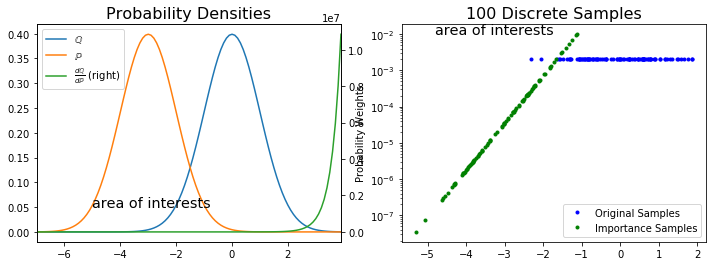

In [11]:
from scipy.stats import norm

x = np.arange(-7, 4, .1)
p = norm.pdf(x)

u = -3 
z = np.exp(-u*x + .5*u*u)

df = pd.DataFrame(np.transpose([norm.pdf(x), norm.pdf(x-u), z]), index=x, 
                  columns=['$\\mathbb{Q}$', '$\\mathbb{P}$', '$\\frac{d \\mathbb{Q}}{d \\mathbb {P}}$'])

fig = figure(figsize=[12, 4])
ax1 = fig.add_subplot(121)

df.plot(ax=ax1, secondary_y=['$\\frac{d \\mathbb{Q}}{d \\mathbb {P}}$']);
ax1.text(-5, .05, "area of interests", size="x-large");
title('Probability Densities', fontsize=16)

subplot(1, 2, 2)

ns = 500
xs_q = np.random.normal(size=[ns]) # Q sample
xs_p = xs_q + u # P sample
qs = 1./ns*np.ones(ns)
zs = np.exp(-u*xs_p + .5*u*u) # R-N derivative
ps = qs*zs

ps = ps/sum(ps)  # normalize

nn = 100
semilogy(xs_q[:nn], qs[:nn], '.b')
semilogy(xs_p[:nn], ps[:nn], '.g')

ylabel('Probability Weights')
legend(['Original Samples', 'Importance Samples'], loc='best');
title('100 Discrete Samples', fontsize=16);

text(-4.8, 1e-2, "area of interests", size="x-large");

Suppose $\tilde x \sim N(0, 1)$ in $\mathbb Q$ measure, but we want to sample more in the area of interests around $d = -3$: 
$$ \renewcommand{intf}{\int_{-\infty}^{\infty}}$$
$$ \small \mathbb E^{\mathbb Q} [f(\tilde x)] = \intf f(x) \phi(x) dx = \intf f(x) \frac{\phi(x)}{\phi(x-d)}\phi(x-d) dx 
= \mathbb E^{\mathbb P}[f(\tilde x) \frac{d \mathbb{Q}}{d \mathbb {P}}] $$

$$ \small \frac{d \mathbb{Q}}{d \mathbb {P}} = \frac{\phi(x)}{\phi(x-d)} = \exp \left(-\frac{1}{2}\left(x^2 - (x-d)^2\right)\right) = \exp(-xd + \frac{1}{2}d^2) $$

## One-factor Gaussian copula

The one factor Gaussian copula model is by far the most [infamous](http://archive.wired.com/techbiz/it/magazine/17-03/wp_quant?currentPage=all) model in quant finance, 

$$\tilde x_i = \sqrt{\rho} \tilde m + \sqrt{1-\rho} \tilde \epsilon_i$$

* it is a one factor correlation model, $x_i$ represents asset returns
* $\tilde m, \tilde \epsilon_i$ are all independent standard normal random variables
* $\tilde x_i, \tilde x_j$ are correlated only through the common market factor $\tilde m$: $\cov(\tilde x_i, \tilde x_j) = \rho\;\cov(\tilde m, \tilde m) = \rho$
* it is silly to blame the financial crisis on such an innocent model ...

## Correlated defaults

$$\renewcommand{ind}{1{\hskip -2.5 pt}\hbox{l}}$$
The one-factor Gaussian copula is often used to model the correlated defaults,

1. We first draw the normal market factor $m$ and correlated normals $x_i$ for each issuers
$$\tilde x_i = \sqrt{\rho} \tilde m + \sqrt{1-\rho} \tilde \epsilon_i$$
2. If an issuer's survival probability is $p_i(t)$ at time $t$, then we can draw the default
time $\tilde \tau$ as:
$$ p_i(\tilde \tau_i) = \Phi(\tilde x_i) \iff \tilde \tau_i = p_i^{-1}(\Phi(\tilde x_i))$$  
3. the coresponding default indicator at time $t$ is: 
$$\ind(\tau_i < t) = \ind(\Phi(x_i) > p_i(t))$$

The resulting default time $\tau_i$ and default indicators $\ind_i$ are correlated through $m$

## Draw default times



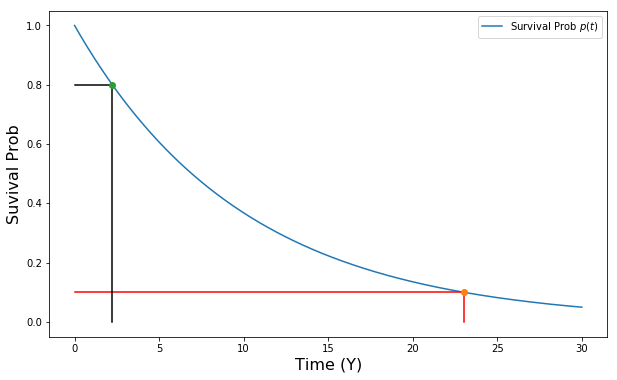

In [12]:
figure(figsize=[10, 6])
ts = np.arange(0, 30, .01)
h = .1
p = np.exp(-h*ts)
plot(ts, p)
xlabel('Time (Y)', fontsize=16)
ylabel('Suvival Prob', fontsize=16)

u = .1
t = -np.log(u)/h
plot([0, t], [u, u], 'r')
plot([t, t], [0, u], 'r')
plot(t, u, 'o');

u = .8
t = -np.log(u)/h
plot([0, t], [u, u], 'k')
plot([t, t], [0, u], 'k')
plot(t, u, 'o');
legend(['Survival Prob $p(t)$']);

* given a uniform random variable $\tilde u$, the default time is $p^{-1}(\tilde u)$.

## Incremental risk charge model

IRC is part of the Basel 2.5 capital requirement for credit risks:
* it is defined to be the 1Y 99.9% quantile of the portfolio loss, assuming the portfolio position is held constant
* only captures the default and rating migration, but not spread volatility

A stylized IRC example:
* only consider the default risk, ignore the trade aging
* portfolio: 100 long CDS positions with \$10MM notional each
* 5 names' 1Y survival probability is 0.95, the rest is 0.99
* recovery given default is uniform between [10%, 50%]
* the correlation of default is governed by the 1F Gaussian copula with 70% correlation

## Straight Monte Carlo for IRC

The IRC can be computed using straight MC. 
* we generate a large number of PnL scenarios, and read out the 99.9% quantile
* to estimate the MC error, we have to apply batching (why?)

The straight MC converges slowly:
* only a small percentage of the scenarios hit the 99.9% tail.

In [13]:
nn, rho = 100, .7
nsim = 40000
p = .99*np.ones(nn)
p[:5] = .95
b = 20
lgdl = 5e6
lgdh = 9e6

def irc0(nsim) :
    es = np.random.normal(size=[nn+1, nsim])
    xs = np.array([np.sqrt(rho)*es[0, :] + np.sqrt(1-rho)*e for e in es[1:, :]]).T
    lgd = np.random.uniform(lgdl, lgdh, size=nsim)

    pnls = np.sum(np.greater(norm.cdf(xs), p), 1)*lgd
    return np.percentile(pnls, 99.9), pnls

tic = time.clock()
ircs0 = [(irc0(nsim))[0] for i in range(b)]
t0 = time.clock() - tic

In [14]:
df = pd.DataFrame([nsim, np.mean(ircs0), np.std(ircs0)/np.mean(ircs0), t0/b], index=['paths', 'value', 'rel error', 'run time(s)'], 
                  columns=['IRC'])
fmt.displayDF(df.T, "3g", 4)    

,paths,value,rel error,run time(s)
IRC,4e+04,5.03e+08,0.0429,0.392


## Shift the common factor

A natural variable to shift is the market factor $\tilde m$, this effectively steers the sampling to those scenarios with a lot of defaults:

In [15]:
def irc1(nsim, d) :
    es = np.random.normal(size=[nn+1, nsim])
    xs = np.array([np.sqrt(rho)*(es[0, :] - d) + np.sqrt(1-rho)*e for e in es[1:, :]]).T
    lgd = np.random.uniform(lgdl, lgdh, size=nsim)

    pnls = np.sum(np.greater(norm.cdf(xs), p), 1)*lgd
    ws = (np.exp(d*es[0, :]))/nsim
    
    s_pnls, s_ws = zip(*sorted(zip(pnls, ws)))
    cws = np.cumsum(s_ws/np.sum(s_ws))
    return s_pnls[np.searchsorted(cws, .999)-1], cws, s_pnls

var1 = []
mean1 = []
ds = np.arange(-2.5, 0.1, .25)
for d in ds :
    ircs = [(irc1(nsim, d))[0] for i in range(b)]
    var1.append(np.var(ircs))
    mean1.append(np.mean(ircs))

In [16]:
uo = -1.5

tic = time.clock()
ircs1 = [irc1(nsim, uo)[0] for i in range(b)]
t1 = time.clock() - tic

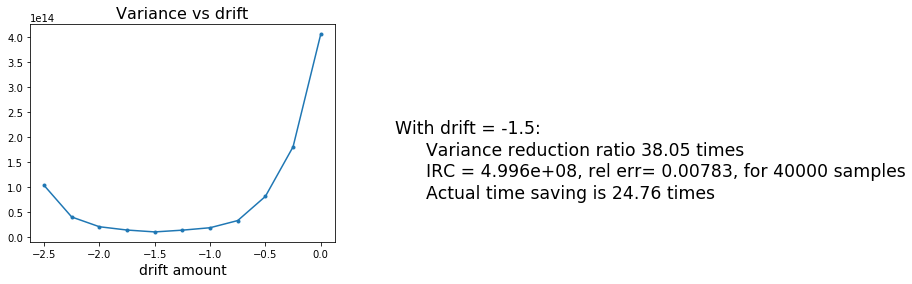

In [17]:
fig = figure(figsize=[12, 4])
subplot(1, 2, 1)
plot(ds, var1, '.-')
xlabel('drift amount', fontsize=14)
title('Variance vs drift', fontsize=16);
ax = fig.add_subplot(122)
ax.set_axis_off()
ax.text(0, .5, "With drift = -1.5:", size="xx-large")
ax.text(.1, .4, "Variance reduction ratio %.2f times" % (var1[-1]/min(var1)), size="xx-large");
ax.text(.1, .3, "IRC = %.4g, rel err= %.3g, for %d samples" % (np.mean(ircs1), np.std(ircs1)/np.mean(ircs1), nsim), size="xx-large")
ax.text(.1, .2, "Actual time saving is %.2f times" % (t0/t1*np.var(ircs0)/np.var(ircs1)), size="xx-large");

* a shift of $\tilde m$ around -1.5 gives the most variance reduction
* here we followed the convesion that negative $\tilde m$ means to more defaults

## How is the variance reduced?


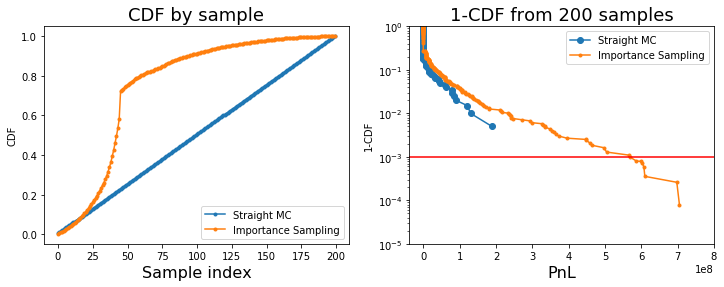

In [18]:
uo = -1.5

nsim = 200
_, pnl1 = irc0(nsim)
_, w2, pnl2 = irc1(nsim, uo)

pnl1 = sorted(pnl1)
w1 = np.arange(1, nsim + 1)*1./nsim

figure(figsize=[12, 4])
subplot(1, 2, 1)
plot(np.transpose([w1, w2]), '.-');
title('CDF by sample', fontsize=18)
xlabel('Sample index', fontsize=16)
legend(['Straight MC', 'Importance Sampling'], loc='best')
ylabel('CDF');

subplot(1, 2, 2)
semilogy(pnl1, 1-w1, 'o-')
semilogy(pnl2, 1-w2, '.-')
axhline(1e-3, color='r')
title('100 Samples')
xlabel('PnL', fontsize=16)
ylabel('1-CDF')
title('1-CDF from 200 samples', fontsize=18)
legend(['Straight MC', 'Importance Sampling'], loc='best')
ylim(1e-5, 1);

The Gaussian copula is a simple static model, 
* it only gives the $\mathcal{F}_0$ distribution of defaults.

What if our model involves a stochastic process?

## Equivalent views

Recall the change of measure for a standard normal RV $\tilde x$ in measure $\mathbb Q$:

$$ \small \mathbb E^{\mathbb Q} [f(\tilde x)] = \intf f(x) \phi(x) dx = \intf f(x) \frac{\phi(x)}{\phi(x-d)}\phi(x-d) dx 
= \mathbb E^{\mathbb P}[f(\tilde x) \frac{d \mathbb{Q}}{d \mathbb {P}}] $$

$$ \small \frac{d \mathbb{Q}}{d \mathbb {P}} = \frac{\phi(x)}{\phi(x-d)} = \exp \left(-\frac{1}{2}\left(x^2 - (x-d)^2\right)\right) = \exp(-xd + \frac{1}{2}d^2) $$

We can also write $\tilde x = \tilde w + d$, where $\tilde w$ is standard normal in $\mathbb P$:

$$\small \mathbb E^{\mathbb Q} [f(\tilde x)] = \mathbb E^{\mathbb P}[f(\tilde x) \frac{d \mathbb{Q}}{d \mathbb {P}}] = \mathbb E^{\mathbb P}[f(\tilde w + d) \frac{d \mathbb{Q}}{d \mathbb {P}}] 
$$

$$ \small \frac{d \mathbb{Q}}{d \mathbb {P}} = \frac{\phi(w+d)}{\phi(w)} = \exp(-wd - \frac{1}{2}d^2) $$

These two expression are equivalent in representing importance sampling around $d$, this leads to something very important.

## Girsanov theorem

Given a 1-D Brownian $w^{\mathbb P}(t)$ in the $\mathbb P$ measure, and a drifted process $x(t)$:

$$  d x(t) = \theta(t) dt + d w^{\mathbb P} (t)  $$

The process:
$$ m(t) = \exp\left(- \int_0^t \theta(s) d w^{\mathbb P}(s) - \frac{1}{2}\int_0^t \theta^2(s) \; ds \right)$$ 
is a martingale in $\mathbb P$: $\mathbb E^{\mathbb P}[m(t) | \mathcal{F}_s] = m(s) $, then: 
* $x(s)$ for $s < t $ is a standard Brownian motion, $w^{\mathbb Q}(t)$, in the measure $\mathbb{Q}$ defined by the Radon-Nikodym derivative $\frac{d \mathbb Q}{d \mathbb P} = m(t)$.

when $\theta(t)$ is a constant: $m(t) = \frac{d \mathbb Q}{d \mathbb P}  = \exp\left(-\theta w^{\mathbb P}(t) - \frac{1}{2} \theta^2t \right) $.

## Girsanov in one chart

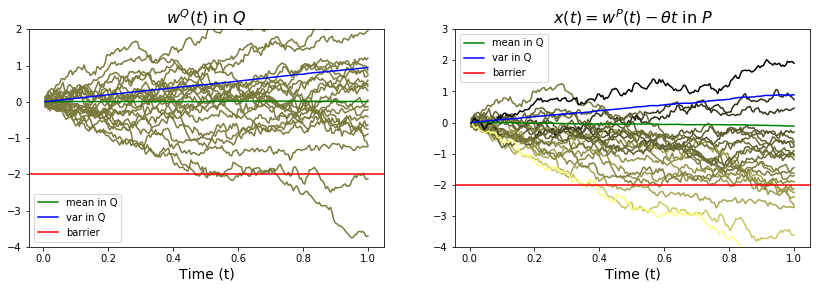

In [19]:
#<img src=http://upload.wikimedia.org/wikipedia/commons/b/b3/Girsanov.png width=600 height=400>
def giranov_w(w, theta, t) :
    return np.exp(-theta*w - .5*theta*theta*t)

ns = 5000

dt = .005
t = 1
ts = np.arange(dt, t+1e-6, dt)

d = -1.5
u = d*ts
e = np.random.normal(size=[ns, len(ts)])*sqrt(dt)
w = np.cumsum(e, 1)
wd = w + u

# the radon-nikodym derivative
mt = giranov_w(w[:,-1], d, t)
mt = mt/sum(mt)*ns  # it is more accurate to force R-N sum up to 1 
thr = -2

# use log scaled color scheme to bring out low prob
wgs = np.log(1./ns/mt) # inverse, darker color for bigger prob weights
wgs = wgs - np.min(wgs)
wgs = wgs/np.max(wgs)
wgs = wgs # adjust the dynamic range

bc = np.array([1, 1, .5])

fig = figure(figsize=[14, 4])

ni = np.array(list(range(20)) + [mt.argmin(), mt.argmax()])
lw = 1.5

ax1 = fig.add_subplot(121)

plot(ts, w[ni].T, c= bc*np.mean(wgs), label=None);
plot(ts, np.mean(w, 0), lw=lw, c='g', label='mean in Q')
plot(ts, np.var(w, 0), lw=lw, c='b', label='var in Q')
ax1.axhline(thr, c='r', lw=lw, label='barrier')
legend(loc='best')
ylim(-4, 2)

xlabel('Time (t)', fontsize=14)
title('$w^Q(t)$ in $Q$', fontsize=16)


ax2 = fig.add_subplot(122)

for w1, gs in zip(wd[ni], wgs[ni]) :
    plot(ts, w1, c=bc*gs, label=None);

plot(ts, mt.dot(wd)/ns, lw=lw, c='g', label='mean in Q')
plot(ts, mt.dot(wd*wd)/ns, lw=lw, c='b', label='var in Q')
ax2.axhline(thr, c='r', lw=lw, label='barrier');
legend(loc='best')
ylim(-4, 3)

xlabel('Time (t)', fontsize=14)
title(r'$x(t) = w^P(t) - \theta t$ in $P$', fontsize=16);

* the color in $\mathbb P$ represents the $\frac{d \mathbb Q}{d \mathbb P} = m(t=1Y)$
* the $\frac{d \mathbb Q}{d \mathbb P} = m(t)$ are per path, convenient for MC
* sampling $x(t)$ in $\mathbb P$ is equivalent to sample a $w^{\mathbb Q}(t)$ in $\mathbb Q$.  
* we can steer $x(t)$ to any arbitrary area of interests in $\mathbb P$
* effective variance reduction for deeply OTM barriers and options

## Understand Girsanov

Given a $\mathbb P$ Brownian motion $w^{\mathbb P}(s)$, we try to find a $\mathbb Q$ under which:
* $\frac{x(s)}{\sqrt s} = \frac{w^{\mathbb P}(s) + \theta s}{\sqrt s} = \frac{w^{\mathbb P}(s)}{\sqrt s} + \theta \sqrt s$ is standard normal

We can compute the $\frac{d \mathbb Q}{d \mathbb P}$ directly from normal PDFs as:

$$ \small \frac{d \mathbb Q}{d \mathbb P} = \phi(\frac{w^{\mathbb P}(s)}{\sqrt s} + \theta \sqrt s)/\phi(\frac{w^{\mathbb P}(s)}{\sqrt s})
= \exp(-\theta w^{\mathbb P}(s) - \frac{1}{2} \theta^2 s) = m(s)  $$

Using $m(s)$ is a $\mathbb P$ martingale:

$$ \small \mathbb E^{\mathbb Q}[x(s)] = \mathbb E^{\mathbb P}[x(s) m(s)]  =\mathbb E^{\mathbb P}[x(s) \mathbb E^{\mathbb P}[m(t) | \mathcal{F}_s]]  = \mathbb E^{\mathbb P}[x(s) m(t)] $$

therefore under $\mathbb Q$ defined by $\frac{d \mathbb Q}{d \mathbb P} = m(t)$:
* $\frac{x(s)}{\sqrt s} = \frac{1}{\sqrt s}(w^{\mathbb P}(s) + \theta s)$ is standard normal for any $s < t$

## Reflection principle

What is the probability of a Brownian hitting a barrier $b > 0$ before time $t$?
<img width=400 height=400 src=http://upload.wikimedia.org/wikipedia/commons/6/63/Wiener_process_and_its_reflection_upon_reaching_a_crossing_point.png>
$$ \mathbb P [\sup_{s<t} \left(w(s)\right) > b)] = 2\mathbb P[w(t) > b] $$

* the results are similar for hitting a lower barrier $b < 0$
* Girsanov theorem can be used to compute the probability of a drifted process $d x(t) = \theta dt + dw(t)$ hitting the barrier by time $t$.

## Girsanov in multimension

Girsanov theorem is easily extendible to independent multi-D Brownians:

$$\begin{array}{l}
\small
& \int f(x_1, \cdots, x_n) p(x_1, \cdots, x_n) d x_1 \cdots d x_n \\
&= \int f(x_1, \cdots, x_n) p_1(x_1) \cdots p_n(x_n) d x_1 \cdots d x_n \\
&= \int \left(\int f\left(x_1, \cdots, x_n\right) p_1(x_1) dx_1\right) p_2(x_2) dx_2 \cdots p_n(x_n) d x_n 
\end{array}$$

* where $p(\cdot)$ are probability density functions
* expectation of independent RVs reduces to 1-D expectations

## Girsanov with correlated Brownians

Transform to independent Brownians first:

$$d \bs w(t) = M d \bs z(t)$$

* correlation matrix $C dt = d \bs w \; d \bs w^T$
* $d \bs z(t)$ is uncorrelated multi-d Brownian motions

Cholesky decomposition: $M = L$
* $C = LL^T$: $d \bs w(t) d \bs w(t)^T = L \bs z(t) \bs z(t) L^T = C dt$

PCA analysis (EVD): $M = RE$
* $C = R \Lambda R^T = R E E^TR^T$, both $\Lambda$ and $E$ are diagonal
* $d \bs w(t) d \bs w(t) ^T = RE d \bs z(t) d \bs z(t)^T E^T R^T = R \Lambda R^T dt = C dt$
* often it is good enough to just shift the first principal component

# Low discrepency sequence

Stephen Sondheim: art, in itself, is an attempt to bring order out of chaos.

In [20]:
# need to do "pip install sobol_seq"
from sobol_seq import i4_sobol_generate
def sobol(dim, n, skip) :
    s = i4_sobol_generate(dim, n+skip)
    return s[skip:, :].T

## Coverage of pseudo random samples

Random sampling:

* it features obvious holes in the sample coverage
* leading to rather slow convergence of $\propto \frac{1}{\sqrt{n}}$

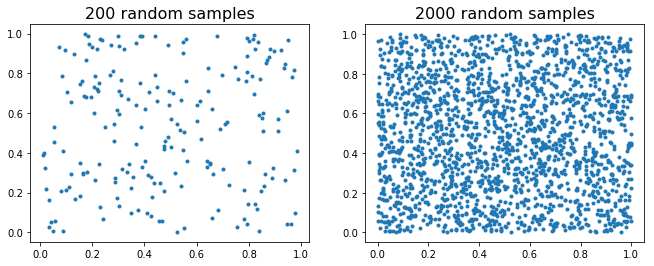

In [21]:
es = np.random.uniform(size=[2, 2000])
figure(figsize=[11, 4])

subplot(1, 2, 1)
n = 200
title('%d random samples' % n, fontsize=16)
plot(es[0,:n], es[1, :n], '.')

subplot(1, 2, 2)
n = 2000
title('%d random samples' % n, fontsize=16)
plot(es[0,:n], es[1, :n], '.');

## Low discrepency sequence

Low discrepency sequence (LDS) places samples in a methodical and deterministic fashion:
* the whole sampling space is evenly covered:
* sucessive addition of sample points leads to uniformly better coverage
* also known as quasi random sequence (QRS)

There are many types of low discrepency sequence:
* e.g. Sobol sequence, Halton sequence

MC with low discrepency sequence:
* easy to implement: just replace the uniform random number generator
* variance has to be estimated using batching method

## LDS vs PRS

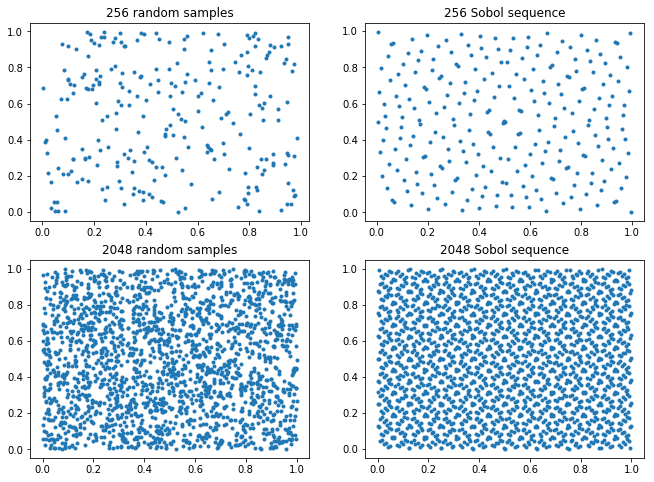

In [22]:
#from sobol_lib import i4_sobol_generate as sobol
x = sobol(2, 5000, 0)

figure(figsize=[11, 8])
subplot(2, 2, 1)
m = 256
plot(es[0, :m], es[1, :m], '.')
title('%d random samples' % m)
subplot(2, 2, 2)
plot(x[0, :m], x[1, :m], '.')
title('%d Sobol sequence' % m)

subplot(2, 2, 3)
m = 2048
plot(es[0, :m], es[1, :m], '.')
title('%d random samples' % m)
subplot(2, 2, 4)
plot(x[0, :m], x[1, :m], '.')
title('%d Sobol sequence' % m);

## LDS and dimensionality

LDS gives exellent convergence for low to medium number of dimensions:
* popular LDS converges at $\propto \frac{\log^n(d)}{n}$, where $d$ is dimensionality and $n$ is the number of samples.
* much faster than the convergence of random samples of $\propto \frac{1}{\sqrt{n}}$


LDS does not work well for very high dimensionalities:

* The coverage deteriorates when dimensionality > 20

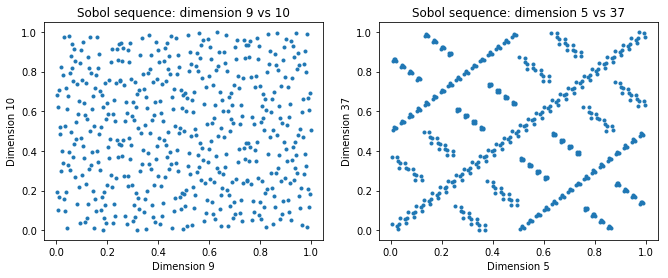

In [23]:
x = sobol(40, 500, 0)

figure(figsize=[11, 4])
subplot(1, 2, 1)
plot(x[8, :], x[9, :], '.')
xlabel('Dimension 9')
ylabel('Dimension 10')
title('Sobol sequence: dimension 9 vs 10')

subplot(1, 2, 2)
plot(x[5,:], x[37, :], '.')
xlabel('Dimension 5')
ylabel('Dimension 37')
title('Sobol sequence: dimension 5 vs 37');

## Common mistakes in using LDS

LDS is dimension specific,

* we have to produce and consume the LDS in the **same** number of dimensions
* we cannot regroup the LDS into different number of dimensions

If we draw 512 numbers from 1-D Sobol sequence, then split them into two groups to cover a two dimensions grid: 

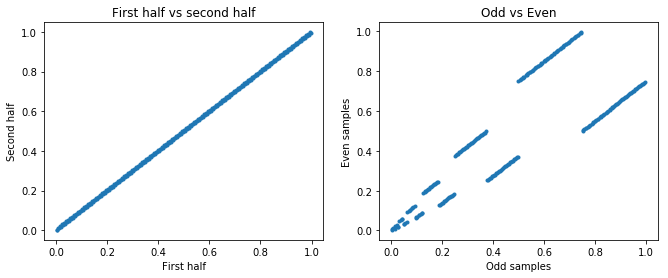

In [24]:
x = sobol(1, 512, 0)[0]
figure(figsize=[11, 4])
subplot(1, 2, 1)
plot(x[:256], x[256:], '.')
xlabel('First half')
ylabel('Second half')
title('First half vs second half')

subplot(1, 2, 2)
plot(x[::2], x[1::2], '.')
xlabel('Odd samples')
ylabel('Even samples')
title('Odd vs Even');

## LDS and Brownian motion

Given a LDS sequence $\hat {\bs d}$,  $\Phi^{-1}(\hat {\bs d})$ could be used as the normal increments to construct Brownian motions:
* works well for problems with low dimensionalities, i.e.,  <20
* may be problematic due to poor coverage for higher dimensionalities

In the Asian option example, 
* there are 12 dimensions for 12 monthly observations
* the variance reduction is about 20-60 times using Sobol sequence, but it varies with the number of paths

In [25]:
p = 2**15
n = 12
b = 20

es = np.random.normal(size=[p, n])
tic = time.clock()
u0, e0 = mc0(p0, es)
t0 = time.clock() - tic

uss = []
u_lds = sobol(n, b*p, 0)
tic = time.clock()
for i in range(b) :
    lds = norm.ppf(u_lds[:, i*p:(i+1)*p]).T
    u1, _ = mc0(p, lds)
    uss.append(u1)
t1 = time.clock() - tic

vf = e0*e0/np.var(uss)

In [26]:
df = pd.DataFrame([[p, u0, e0, t0], [p, np.mean(uss), np.std(uss), t1/b]], 
                  index=['PRS', 'LDS'], columns=['Paths', 'Price', 'Error (Std)', 'Time(s)'])

fmt.displayDF(df, "4g", 4)

,Paths,Price,Error (Std),Time(s)
PRS,32768,1.639,0.007318,0.009796
LDS,32768,1.637,0.0009927,0.05028


In [27]:
print(vf, b)

54.3523795954 20


## LDS with Brownian Bridge

Often in practice, we run into problems with more dimensions than 30,
 * under these situation, LDS could be dangerous.

A useful technique is to use LDS at only at a few key tenors, then use Brownian Bridge to fill in the gaps.

* we used a 1-D LDS at the option maturity, the rest is built with BB
* a modest variance reduction is achieved in the Asian option example
* more reduction is expected if we sample multiple time steps with LDS

In [28]:
ubs = []
lds_bb = norm.ppf(np.array(sobol(1, b*p, 0)[0])+1e-10)*sqrt(n)
    
tic = time.clock()
for i in range(b) :
    es = np.random.normal(size=[p, n])
    es_u = np.sum(es, 1)
    d = (lds_bb[i*p:(i+1)*p] - es_u)/n
    es_bb = (es.T + d).T

    ubb, ebb = mc0(p, es_bb)
    ubs.append(ubb)
t2 = time.clock() - tic

vf = e0*e0/np.var(ubs)

In [29]:
df = pd.DataFrame([[p, u0, e0, t0], [p, np.mean(ubs), np.std(ubs), t2/b]], 
                  index=['PRS', 'LDS with BB'], columns=['Paths', 'Price', 'Error (Std)', 'Time(s)'])

fmt.displayDF(df, "4g", 4)

,Paths,Price,Error (Std),Time(s)
PRS,32768,1.639,0.007318,0.009796
LDS with BB,32768,1.636,0.005965,0.02702


# Other Techniques

## Moment matching

Shift and scale the random samples so that they have the desired moments.
 * often applied to normal random numbers,
 * has limited variance reduction effects,

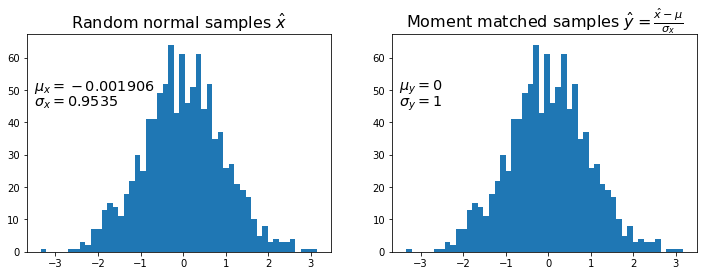

In [30]:
x = np.random.normal(size = 1000)
u = np.mean(x)
vol = np.std(x)
y = (x-u)/vol

figure(figsize=[12, 4])
subplot(1, 2, 1)
hist(x, 50);

text(-3.5, 50, '$\\mu_x=%.4g$' % np.mean(x), size='x-large');
text(-3.5, 45, '$\\sigma_x=%.4g$' % np.std(x), size='x-large');
title('Random normal samples $\\hat x$', fontsize=16)

subplot(1, 2, 2)
hist(x, 50)
text(-3.5, 50, '$\\mu_y=0$', size='x-large');
text(-3.5, 45, '$\\sigma_y=1$', size='x-large');
title('Moment matched samples $\\hat y = \\frac{\\hat x - \\mu}{\\sigma_x}$', fontsize=16);

## Stratification

Stratification is essentially bucketing, in order to better capture the true distribution, 

Consider drawing uniform random numbers in 1-D:
* divide the range [0, 1] into $n$ buckets (or strata), each with length $\frac{1}{n}$
* map the unform to each bucket in a round robin manner: 

$$\hat v_i = \frac{(i \mod n) + \hat u_i}{n}$$

* $\hat v_i$ are stratified samples, and it can be converted to other distributions using inverse CDF

Stratification is similar to LDS in spirit, but:
* more difficulty in extending to higher dimensions, the number of strata expodes with dimensions
* less popular than LDS in practice

In [31]:
def stratify(u, bs, shuffle) :
    b = len(bs)
    r = len(u)//b + 1
    sb = []
    
    for i in range(r) :
        if shuffle :
            np.random.shuffle(bs)
        sb = sb + bs.tolist()
            
    return [1.*(i + x)/b for x, i in zip(u, sb)]

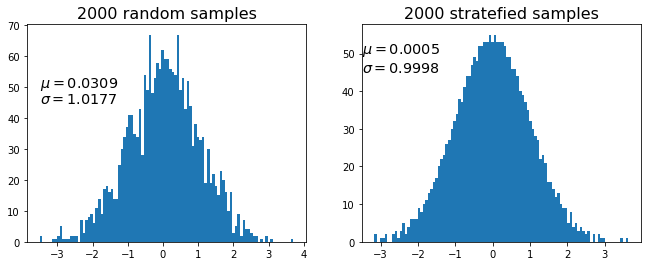

In [32]:
bs = np.arange(1000)
n = 2000
u = np.random.uniform(size=n)
v = stratify(u, bs, False)

figure(figsize=[11, 4])

subplot(1, 2, 1)
title('%d random samples' % n, fontsize=16)
x = norm.ppf(u)
hist(x, 100);
text(-3.5, 50, '$\\mu=%.4f$' % np.mean(x), size='x-large');
text(-3.5, 45, '$\\sigma=%.4f$' % np.std(x), size='x-large');

subplot(1, 2, 2)
title('%d stratefied samples' % n, fontsize=16)
y = norm.ppf(v)
hist(y, 100);
text(-3.5, 50, '$\\mu=%.4f$' % np.mean(y), size='x-large');
text(-3.5, 45, '$\\sigma=%.4f$' % np.std(y), size='x-large');

## Practical matters in variance reduction

**Important**: Different methods do not mix well.
  * combining two methods together do not necessarily yield more variance reduction, 
  * it often messes things up
  

Do not abuse methods that are easy to implement, such as antithetic variate and LDS:
  * Control variate and importance sample deserve more attention

## Variance reduction summary

<small>

| Methods | Effectiveness | Generality | Batching? | Implementation | Best for |
| :---: | :---: | :---: | :---: | :---: | :---: |
| Antithetic Variate | low | high | no | easy | linearish payoffs |
| Control Variate | very high | low | no | hard | has vanila proxy |
| Importance Sampling | high | low | yes | hard | rare events | 
| Low Discrepency Sequence | vary | high | yes | easy | low dimensionality |
| Moment Matching | low | high | yes | easy | ?? |
| Stratified Sampling | vary | low | yes | easy | low dimensionality |

# Assigment

Recommented reading:

* Andersen and Piterbarg: Chapter 3.3-3.4

Homework:

* Complete [homework set 7](http://yadongli.github.io/nyumath2048)